<a href="https://colab.research.google.com/github/NisthaRaj/Data-Scientist101/blob/main/Time_Series_Nixtla_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install nixtla>=0.5.1

In [2]:
import os
os.environ['TIMEGPT_API_KEY'] = 'nixak-4tolF4dJaJtj8I7SB5rop9Wdswm0DlqIvMPMpojRFPss5Z2sZbDY62G6nQGk49GCq0BR90SUtg1MElAu'
print(os.getenv('TIMEGPT_API_KEY'))

nixak-4tolF4dJaJtj8I7SB5rop9Wdswm0DlqIvMPMpojRFPss5Z2sZbDY62G6nQGk49GCq0BR90SUtg1MElAu


In [3]:
import pandas as pd
import yfinance as yf
from nixtla import NixtlaClient
import os

timegpt_api_key = os.environ["TIMEGPT_API_KEY"]

# Setup NixtlaClient
nixtla_client = NixtlaClient(api_key = timegpt_api_key)


In [4]:
import pandas as pd


def read_tsf_from_file(file_path):
    data = []
    start_date = pd.to_datetime("2002-01-01 00:00:00")

    # Open and read the file from the directory

    with open(file_path, "r") as file:
        for line in file:
            if line.startswith("T"):
                parts = line.strip().split(":")
                unique_id = parts[0] + "-" + parts[1]
                values = list(map(float, parts[3].split(",")[:-1]))

                # Generate datetime index at half-hour intervals

                periods = len(values)
                date_range = pd.date_range(
                    start=start_date, periods=periods, freq="30min"
                )

                # Append to data list

                for dt, value in zip(date_range, values):
                    data.append([unique_id, dt, value])
    # Convert the list of data into a DataFrame

    return pd.DataFrame(data, columns=["unique_id", "ds", "y"])


# Example usage

file_path = "/australian_electricity_demand_dataset.tsf"
demand_df = read_tsf_from_file(file_path)

# Display the dataframe

demand_df.head()


,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
2,T1-NSW,2002-01-01 01:00:00,5014.835118
3,T1-NSW,2002-01-01 01:30:00,4602.755516
4,T1-NSW,2002-01-01 02:00:00,4285.179828


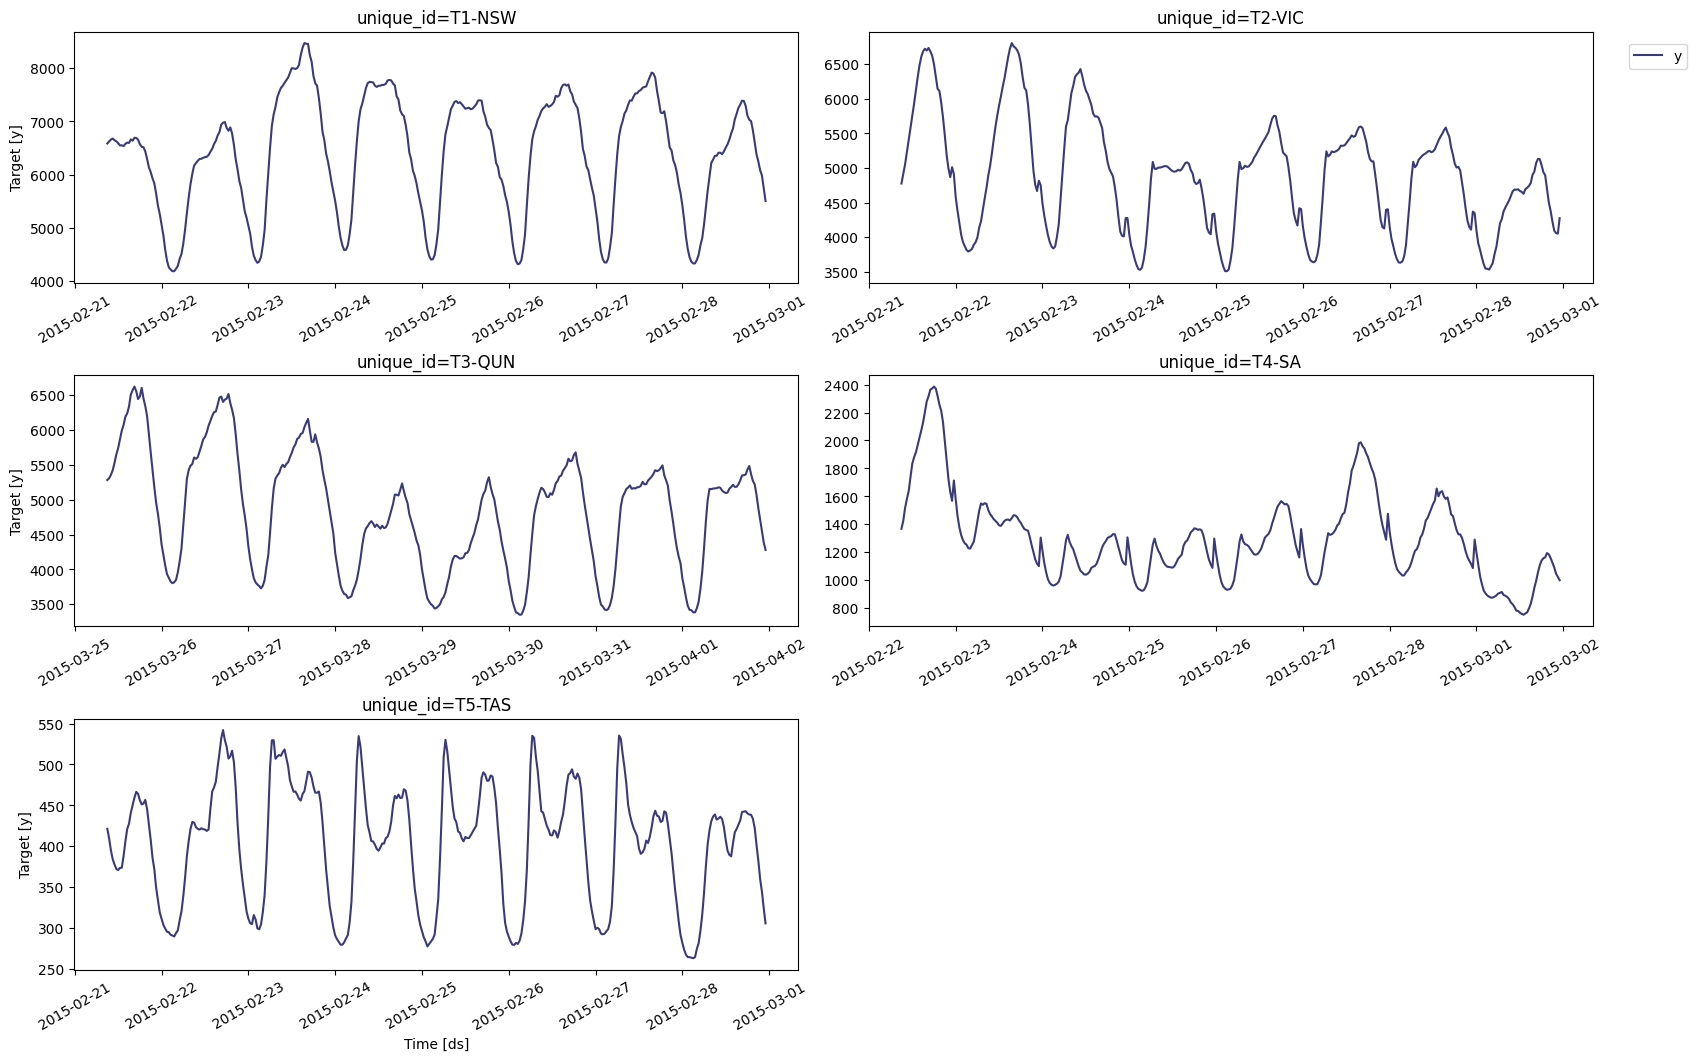

In [5]:
nixtla_client.plot(
    demand_df,
    max_insample_length=365,
)

In [6]:
# Check for duplicates
print("Duplicates in ds:", demand_df['ds'].duplicated().sum())

# Check for missing hourly timestamps
expected = pd.date_range(demand_df['ds'].min(), demand_df['ds'].max(), freq='H')
actual = pd.DatetimeIndex(demand_df['ds'])
missing = expected.difference(actual)
print("Missing hourly timestamps:", len(missing))


Duplicates in ds: 922988


/tmp/ipython-input-6-2012841318.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected = pd.date_range(demand_df['ds'].min(), demand_df['ds'].max(), freq='H')


Missing hourly timestamps: 0


In [7]:
# Check for duplicates
print("Duplicates in ds:", demand_df['ds'].duplicated().sum())


Duplicates in ds: 922988


In [8]:
# Check for missing hourly timestamps
expected = pd.date_range(demand_df['ds'].min(), demand_df['ds'].max(), freq='H')
actual = pd.DatetimeIndex(demand_df['ds'])
missing = expected.difference(actual)
print("Missing hourly timestamps:", len(missing))


/tmp/ipython-input-8-1338605586.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected = pd.date_range(demand_df['ds'].min(), demand_df['ds'].max(), freq='H')


Missing hourly timestamps: 0


In [9]:
import pandas as pd

# Step 1: Convert 'ds' to datetime and sort
demand_df['ds'] = pd.to_datetime(demand_df['ds'])
demand_df = demand_df.sort_values('ds')

# Step 2: Aggregate duplicates by taking the mean of 'y'
demand_df_agg = (
    demand_df
    .groupby('ds', as_index=False)
    .agg({'y': 'mean'})
)

# Step 3: Reindex to strict hourly frequency
full_range = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H')
demand_df_agg= (
    demand_df_agg
    .set_index('ds')
    .reindex(full_range)
    .rename_axis('ds')
    .reset_index()
)

# Step 4: Fill missing values in 'y' using interpolation
demand_df_agg['y'] = demand_df_agg['y'].interpolate()


/tmp/ipython-input-9-676485867.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H')


In [10]:
print("Duplicates:", demand_df_agg['ds'].duplicated().sum())  # should be 0
print("Regular frequency:", pd.infer_freq(demand_df_agg['ds']))  # should print 'H'


Duplicates: 0
Regular frequency: h


In [11]:
anomalies_df = nixtla_client.detect_anomalies(
    demand_df_agg,
    time_col='ds',
    target_col='y',
    freq='H',
)

anomalies_df[anomalies_df["anomaly"] == 1].head()


/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
157,2002-01-12 13:00:00,3169.893999,3777.4927,4336.3590,3218.6265,True
158,2002-01-12 14:00:00,3126.081830,3761.8284,4320.6943,3202.9622,True
159,2002-01-12 15:00:00,3092.513931,3758.5586,4317.4250,3199.6924,True
160,2002-01-12 16:00:00,3110.555768,3717.8352,4276.7010,3158.9690,True
486,2002-01-26 06:00:00,2541.893326,3122.8176,3681.6838,2563.9514,True


In [12]:
demand_df_agg.head(200)
#num = demand_df_agg["unique_id"].nunique()
#print(f"Number of unique ids: {num}")

KeyError: 'unique_id'

In [13]:
anomalies_df.anomaly.value_counts()

,count
anomaly,
False,112302
True,3714


In [14]:
# Plot anomalies
nixtla_client.plot(
    demand_df[demand_df["unique_id"]=="T1-NSW"][0:5000],
    anomalies_df[anomalies_df["unique_id"]=="T1-NSW"][0:5000],
    time_col='ds',
    target_col='y',

)

KeyError: 'unique_id'

Single Series Forecasting with TimeGPT  with the unique_id = T1-NSW

In [14]:
T1_df = demand_df[demand_df["unique_id"]=="T1-NSW"]
T1_df.head()

,ds,unique_id,y
0,2002-01-01 00:00:00,T1-NSW,5714.045004
1,2002-01-01 01:00:00,T1-NSW,5014.835118
2,2002-01-01 02:00:00,T1-NSW,4285.179828
3,2002-01-01 03:00:00,T1-NSW,3942.936134
4,2002-01-01 04:00:00,T1-NSW,3877.679938


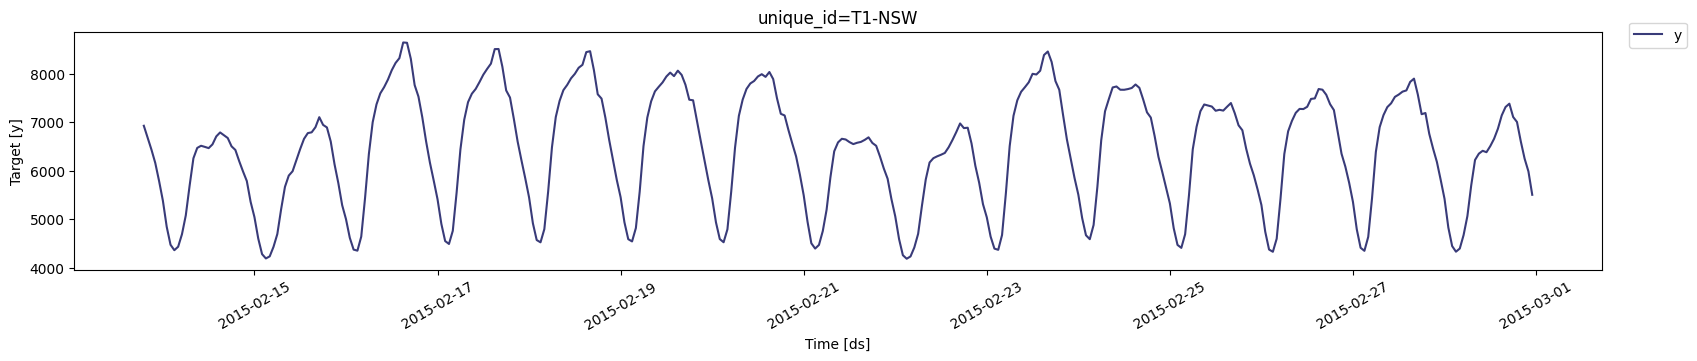

In [15]:
nixtla_client.plot(
    T1_df,
    max_insample_length=365,
)

In [16]:
test_df = T1_df.tail(144) # 3 days = (144 * 0.5h *  1 day/24h)
train_df = T1_df.iloc[-1344:-144] # 25 days = (1200 *0.5h * 1 day/24h)

For forecasting, we will select a better model and set various arguments to improve model performance, specifically:

1.Forecast the next 144 values (3 days).
2.Forecast 90% confidence interval.
3.Fine-tune the model with 60 steps, which is a lot, but it will give a better result.
4.Set loss function to MAE.
5.Use the TimeGPT-1-long-horizon model instead of a simple one.
6.Set time and target columns.

In [17]:
predict_df = nixtla_client.forecast(
    df=train_df,
    h=144,
    level=[90],  # Generate a 90% confidence interval
    finetune_steps=60,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Use the MAE as the loss function for fine-tuning
    model="timegpt-1-long-horizon",  # Use the model for long-horizon forecasting
    time_col="ds",
    target_col="y",
)


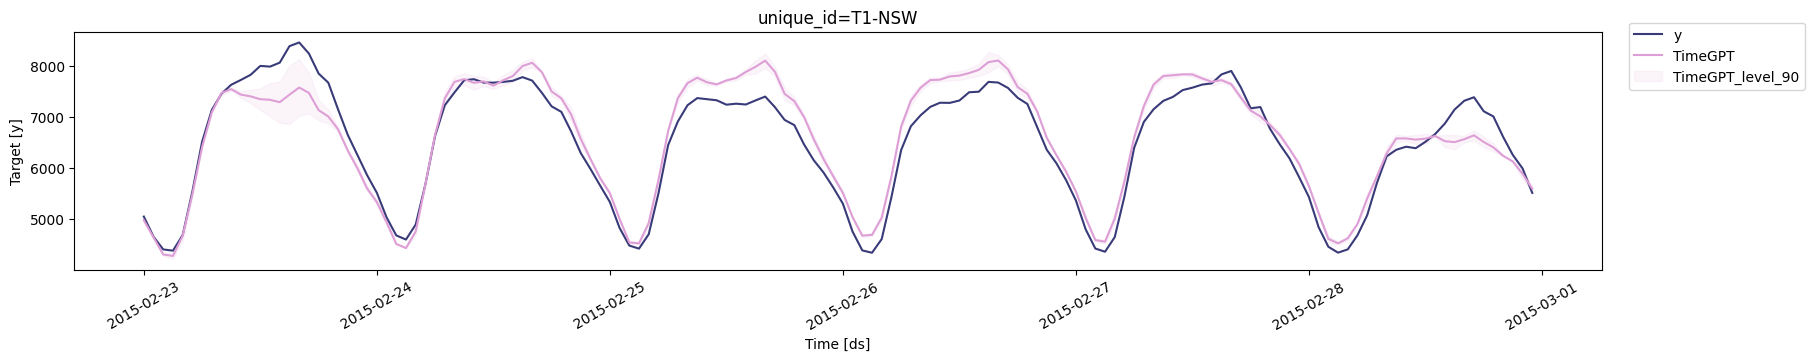

In [18]:
nixtla_client.plot(
    test_df, predict_df, models=["TimeGPT"], level=[90], time_col="ds", target_col="y"
)


In [19]:
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate

predict_df["ds"] = pd.to_datetime(predict_df["ds"])
test_df = pd.merge(test_df, predict_df, "left", ["ds", "unique_id"])
evaluation = evaluate(
    test_df,
    metrics=[mae, rmse, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col="unique_id",
)

average_metrics = evaluation.groupby("metric")["TimeGPT"].mean()
average_metrics

,TimeGPT
metric,
mae,298.110770
rmse,362.819121
smape,0.022319


In [26]:
demand_df.head(200)
num = demand_df["unique_id"].nunique()
print(f"Number of unique ids: {num}")

Number of unique ids: 2


Multi-Series Forecasting with TimeGPT

In [ ]:
values for some randomly chosen unique ID.
test_df = demand_df.groupby("unique_id").tail(144)  # 3 days
train_df = (
    demand_df.groupby("unique_id")
    .apply(lambda group: group.iloc[-1344:-144])
    .reset_index(drop=True)
)  # 25 days